In [39]:
# Integration Sim Test 1

# Housekeeping

import simpy
import vowpalwabbit
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing as mp
from joblib import Parallel, delayed
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [40]:
# Learning simulation (40 rounds each household with impact level given on baseline)

df=pd.read_csv('inttest1.csv')
# reward (treat) must enter as cost (negative) in VW
df['treat']=-df['treat']
dfcb = df
#Treatment menu (in-person short, in-person long, hybrid-short, hybrid-long)
actions=[1,2,3,4]     

In [41]:

#construct data for estimation
train_df = df[df.index < 700]
test_df = df[df.index >= 700]
test_df.reset_index 
X_train=train_df.drop(columns=['Unnamed: 0', 'treat', 'prob', 'user_id'], axis=1, inplace=False)
y_train= train_df['treat']
X_test=test_df.drop(columns=['Unnamed: 0', 'treat', 'prob', 'user_id'], axis=1, inplace=False)
y_test= test_df['treat']
dfcb=dfcb.drop(columns=['Unnamed: 0'], axis=1, inplace=False)
dfcb.describe()


,user_id,s0,i0,treat,action,village,educ,gender,mage,prob
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00
mean,500.500000,207.081862,15.533563,-0.515862,2.509000,10.290000,2.981000,0.479000,39.637000,0.25
std,288.819436,158.687126,8.031185,1.232873,1.098693,5.850652,1.427823,0.499809,11.909033,0.00
min,1.000000,-14.300000,-1.300000,-5.150000,1.000000,1.000000,1.000000,0.000000,20.000000,0.25
25%,250.750000,80.450000,9.787500,-1.181250,2.000000,5.000000,2.000000,0.000000,30.000000,0.25
50%,500.500000,173.750000,14.750000,-0.450000,2.000000,10.000000,3.000000,0.000000,39.000000,0.25
75%,750.250000,297.575000,21.125000,0.225000,3.000000,16.000000,4.000000,1.000000,50.000000,0.25
max,1000.000000,855.500000,47.600000,3.650000,4.000000,20.000000,5.000000,1.000000,60.000000,0.25


In [36]:
def train_xgboost_regressor(train_data, train_labels, test_data, test_labels):
    # Define the XGBoost regressor
    reg = XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        max_depth=4,
        learning_rate=0.18793869,
        gamma=0.03805912,
        min_child_weight=4.9259686,
        subsample=0.89705926,
        colsample_bytree=0.9011847,
        seed=42
    )
    # Train the XGBoost model
    reg.fit(train_data, train_labels)
    # Evaluate the model on the test data
    predictions = reg.predict(test_data)
    mse = mean_squared_error(test_labels, predictions)
    # Return the trained model and the mean squared error
    return reg, mse

In [37]:
# Train xgboost
model, mse = train_xgboost_regressor(X_train, y_train, X_test, y_test)
# Print the MSE
print('MSE:', mse)
import eli5
eli5.show_weights(model, top=-1, feature_names = X_train.columns.tolist()) 

MSE: 0.6006250520620579


In [48]:
def get_cost(s0, i0, action, village, educ, gender, mage, model):
    
    usuario=pd.DataFrame({'s0':s0, 'i0':i0, 'action':action, 'village':village, 'educ':educ, 'gender':gender, 'mage':mage}, index=[1])
    costo=model.predict(usuario)
    return costo[0]

#Update sample probabilities     
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    #sum_prob = np.mean(pmf)
    sum_prob = np.max(pmf)
    for index, prob in enumerate(pmf):
        #sum_prob += prob
        if prob >= sum_prob:
            return index, prob        
        
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label=None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user:{} s0:{} i0:{} village{} educ:{} gender:{} mage:{}\n".format(
        context["user"], context["s0"], context["i0"], context["village"], context["educ"], context["gender"], context["mage"], 
    )   
    
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action:{} \n".format(action)
    # Strip the last newline
    return example_string[:-1]

# Suggest action based on learned reward value
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context, actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

#Simulation setup for users over time
def run_simulation(vw, dfcb, num_iterations, actions, get_action, get_cost, label):
  
    das = []
    act = []
    pr = []
    
    for j in range(len(dfcb)):
        cost_sum = 0.0
        cost_us = []
        act_us = []
        pr_us = []
        for i in range(1, num_iterations + 1):
            
            datos_vw=[]   
            user = dfcb.iloc[j]['user_id']
            gender=dfcb.iloc[j]['gender']
            mage=dfcb.iloc[j]['mage']
            s0=dfcb.iloc[j]['s0']
            i0=dfcb.iloc[j]['i0']
            educ=dfcb.iloc[j]['educ']
            village=dfcb.iloc[j]['village']
            contextos = {"user": user, "s0": s0, "i0":i0, "village":village, "educ":educ, "gender":gender, "mage":mage}
            action, prob = get_action(vw, contextos, actions)
            cost = get_cost(int(s0), int(i0), int(action), int(village), int(educ), int(gender), int(float(mage)), model)
            cost_sum += float(cost)
            if label:
                vw_format=vw.parse(
                    to_vw_example_format(contextos, actions, (action, cost, prob)),
                    vowpalwabbit.LabelType.CONTEXTUAL_BANDIT)
                vw.learn(vw_format)      
            else:
                datos_vw.append(to_vw_example_format(contextos, actions))

            cost_us.append(- cost_sum / i)
            act_us.append(action)
            pr_us.append(prob)
            
        das.append(cost_us)
        act.append(act_us)
        pr.append(pr_us)
                
    return das, act, pr  

# Output plot
def plot_das(num_iterations, das):
    plt.plot(range(1, num_iterations + 1), das)
    plt.xlabel("num_iterations", fontsize=14)
    plt.ylabel("das", fontsize=14) 

IndentationError: expected an indented block (3382866925.py, line 82)

In [47]:
vw1 = vowpalwabbit.Workspace("--cb_explore_adf --epsilon 0.2")
num_iterations=40
das1, act1, pr1 = run_simulation(vw1, dfcb, num_iterations, actions, get_action, get_cost, label=True) 

[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]


KeyboardInterrupt: 

<Axes: >

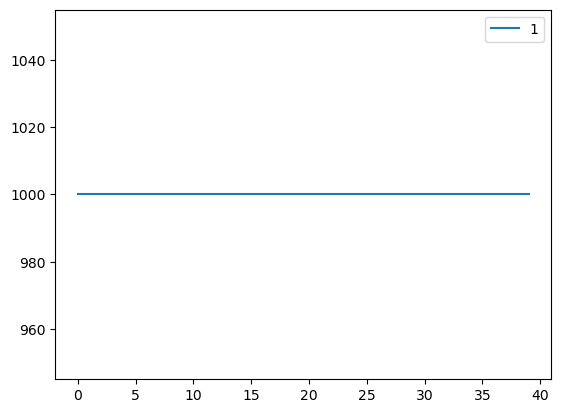

In [24]:
das1df = pd.DataFrame(das1)
act1df = pd.DataFrame(act1)
pr1df = pd.DataFrame(pr1)
das1dfm=das1df.mean(axis=0)
pr1dfm = pr1df.mean(axis=0)
act1s = act1df.apply(pd.Series.value_counts)
act1s = act1s.transpose()
sns.lineplot(data=act1s)

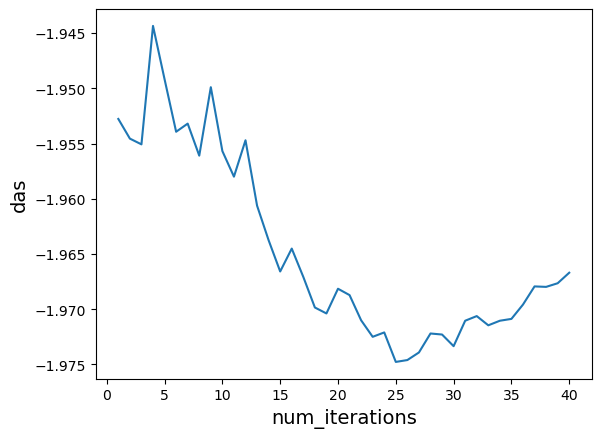

In [19]:
#create column stubs
#test = pd.concat([das1df, act1df, dfcb], axis=1)
plot_das(num_iterations, das1dfm)

In [44]:
vw2 = vowpalwabbit.Workspace("--cb_explore_adf --softmax --lambda 10")
das2, act2, pr2 = run_simulation(vw2, dfcb, num_iterations, actions, get_action, get_cost, label=True)

[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]
[0.25, 0.25, 0.25, 0.25]


KeyboardInterrupt: 

<Axes: >

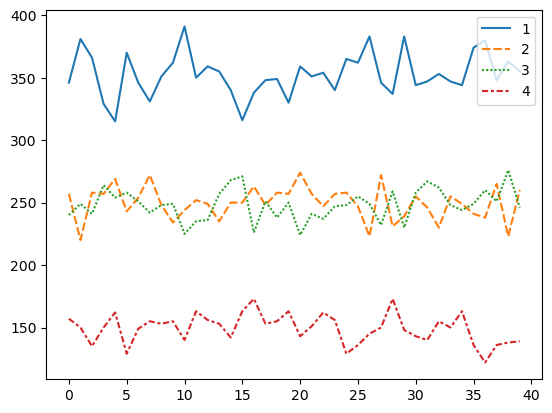

In [12]:
das2df = pd.DataFrame(das2)
act2df = pd.DataFrame(act2)
das2dfm=das2df.mean(axis=0)
act2s = act2df.apply(pd.Series.value_counts)
act2s = act2s.transpose()
sns.lineplot(data=act2s)

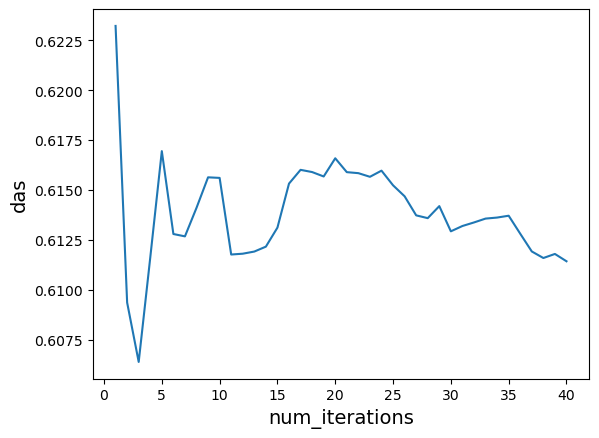

In [13]:
plot_das(num_iterations, das2dfm)

In [14]:
vw3 = vowpalwabbit.Workspace("--cb_explore_adf --quiet --bag 5")
das3, act3 = run_simulation(vw3, dfcb, num_iterations, actions, get_action, get_cost, label=True)

<Axes: >

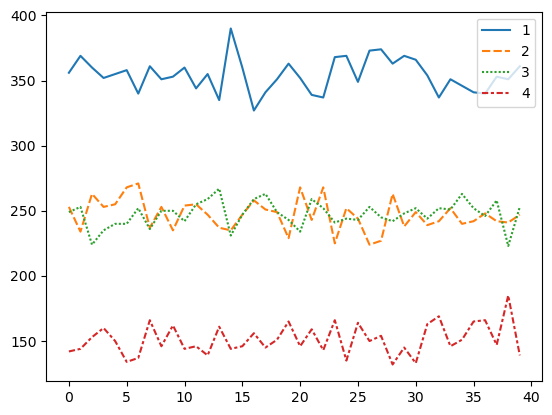

In [15]:
das3df = pd.DataFrame(das3)
act3df = pd.DataFrame(act3)
das3dfm=das3df.mean(axis=0)
act3s = act3df.apply(pd.Series.value_counts)
act3s = act3s.transpose()
sns.lineplot(data=act3s)

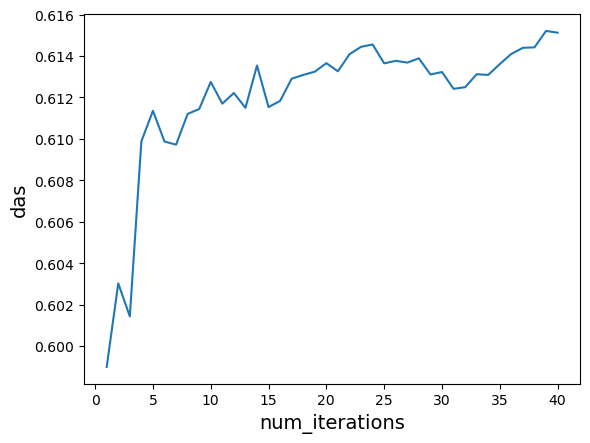

In [16]:
plot_das(num_iterations, das3dfm)

In [17]:
vw4 = vowpalwabbit.Workspace("--cb_explore_adf --quiet --first 100")
das4, act4 = run_simulation(vw4, dfcb, num_iterations, actions, get_action, get_cost, label=True)

<Axes: >

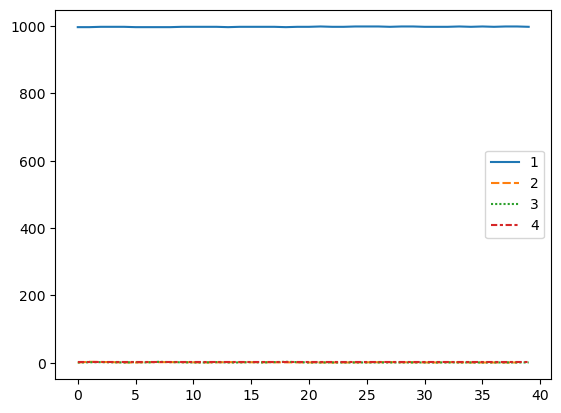

In [18]:
das4df = pd.DataFrame(das4)
act4df = pd.DataFrame(act4)
das4dfm=das4df.mean(axis=0)
act4s = act4df.apply(pd.Series.value_counts)
act4s = act4s.transpose()
sns.lineplot(data=act4s)

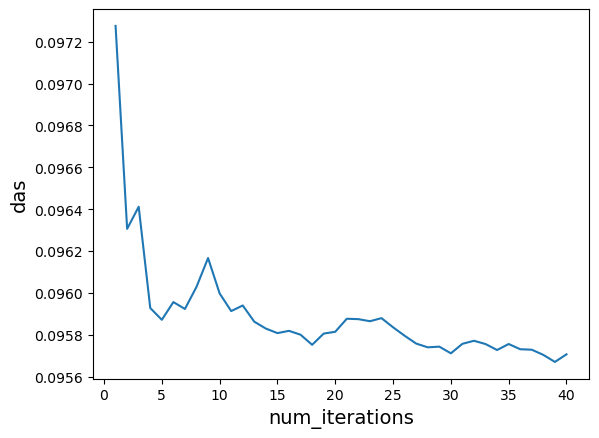

In [19]:
plot_das(num_iterations, das4dfm)

<Axes: xlabel='educ', ylabel='reward'>

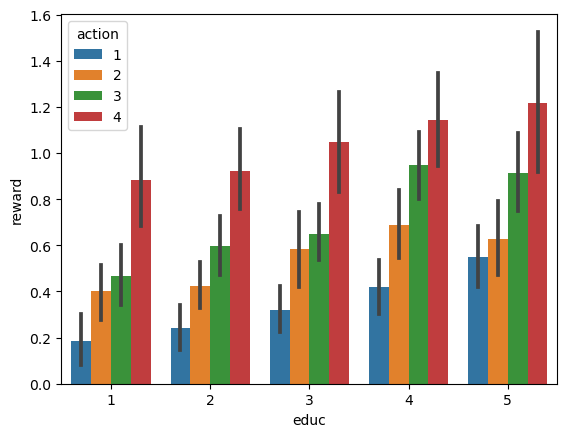

In [41]:
test = pd.concat([das1df[1], act1df[1], dfcb['educ']], axis=1, keys=["reward", "action","educ"])
sns.barplot(data=test, x='educ', y='reward', hue='action')

<Axes: xlabel='educ', ylabel='reward'>

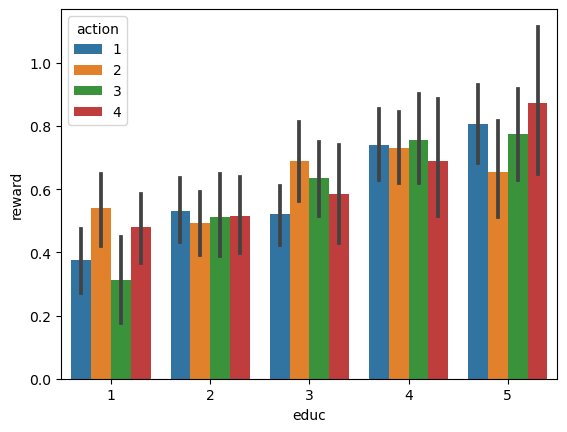

In [42]:
test = pd.concat([das1df[39], act1df[39], dfcb['educ']], axis=1, keys=["reward", "action","educ"])
sns.barplot(data=test, x='educ', y='reward', hue='action')